## decoupling scheme:
$$e^{-\lambda (\hat{n} - N)^2} = \frac{1}{4} \sum_{l = \pm 1, \pm 2} \gamma(l) e^{\mathrm{i} \eta(l) (\hat{n} - N)} + \left( \text{higher order in } \lambda \right)$$

in which $\gamma(+l) = \gamma(-l)$, $\eta(-l) = -\eta(+l)$

In [1]:
import PyPlot; const plt = PyPlot
using LaTeXStrings
include("../src/decouplingScheme.jl")

Δτ = 0.1;
U = 1.5;
gamma, eta = decouplingCoefficients_CjWu(Δτ, U)
gamma1, eta1 = decouplingCoefficients_Assaad(Δτ, U)
f(n) = 0.5 * sum( gamma .* cos.(eta .* n) )
f1(n) = 0.5 * sum( gamma1 .* cos.(eta1 .* n) )
g(n) = exp(-Δτ*U*0.5*n^2)

g (generic function with 1 method)

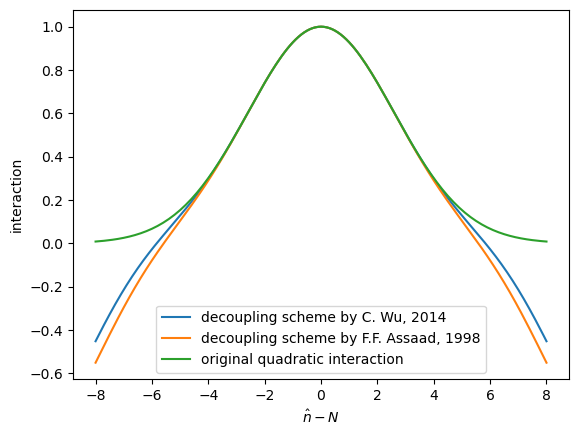

In [2]:
ns = [0.1*x - 8.0 for x in 0:160]
plt.plot(ns, f.(ns), label="decoupling scheme by C. Wu, 2014")
plt.plot(ns, f1.(ns), label="decoupling scheme by F.F. Assaad, 1998")
plt.plot(ns, g.(ns), label="original quadratic interaction")
plt.xlabel(latexstring("\$\\hat{n} - N\$"))
plt.ylabel("interaction")
plt.legend()
plt.show()

the decoupled results, though not exact, is in accordance with the original function in a wide range. C. Wu 2014 offers a scalable and exact way utilizing that $\hat{n}$ has integer eigen values.

## comparison with Exact Diagonalization Calculation

considering a 1d chain with periodic boundary condition, the observable to be studied is

In [3]:
using QuantumLattices
using FileIO
using ProgressMeter
using ExactDiagonalization
using LinearAlgebra

function count1(x)
    sum = 0
    while x != 0
        sum += x % 2
        x = x ÷ 2
    end
    sum
end

function addChemicalP!(mu, m)
    for i in 1:2^(2*N)
        m[i, i] += mu * count1(i-1)
    end
end

N = 6

unitcell = Lattice(:Ring,
    [Point(PID(1), [0.0])],
    vectors=[[1.0]],
    neighbors=1
    )

lattice = Lattice(unitcell, translations"6P")
hilbert = Hilbert(pid=>Fock{:f}(norbital=1, nspin=2) for pid in lattice.pids)
t = Hopping(:t0, -1.0, 1)
U = Hubbard(:U, 4.0)
bases = BinaryBases(1:2*N)
ed = ED(lattice, hilbert, (U, t), TargetSpace(bases))
a = matrix(ed).matrix
addChemicalP!(-2.0, a)

ed_s2 = ED(lattice, hilbert, (Hubbard(:U, -2.0), Hopping(:t0, -0.0, 1)), TargetSpace(bases))
O = matrix(ed_s2).matrix
addChemicalP!(+1.0, O)

In [4]:
betas = [10.0 / x for x in 1:40]
result = []

@showprogress for beta in betas
    x1 = tr(exp(Matrix(-beta*a)))
    x2 = tr(Matrix(O) * exp(Matrix(-beta*a)))
    append!(result, (0.75 / N) * (x2 / x1))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:13:50


In [6]:
y = Dict("sSquare_mean" => result, "beta" => betas)
save("../data/6siteRing_spin2_U=4.0_ED.jld2", y)

In [7]:
y = load("../data/6siteRing_spin2_U=4.0_ED.jld2")

Dict{String, Any} with 2 entries:
  "sSquare_mean" => Any[0.58347, 0.586659, 0.59357, 0.598725, 0.600817, 0.60041…
  "beta"         => [10.0, 5.0, 3.33333, 2.5, 2.0, 1.66667, 1.42857, 1.25, 1.11…

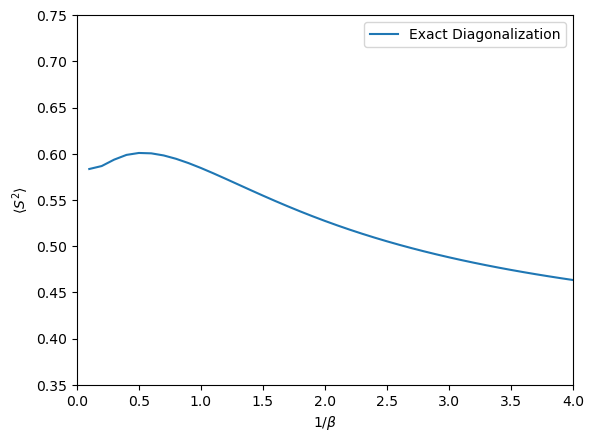

In [10]:
plt.plot(1.0 ./ y["beta"], y["sSquare_mean"], label="Exact Diagonalization")
plt.ylim((0.35,0.75))
plt.xlim((0.0, 4.0))
plt.ylabel(latexstring("\$ \\langle S^2 \\rangle \$"))
plt.xlabel(latexstring("\$1 / \\beta \$"))
plt.legend()
plt.show()